# the guts of SBI: a demo with Sapphire Galaxy Evolution

By T. Lucas Makinen and Viraj Pandya

---

Here we're going to contrain galaxy formation parameters using the [`sapphire`](https://arxiv.org/abs/2211.09755) model. Galaxies are born in dark matter halos, and we can parameterize aspects of their evolution and interaction with extragalactic winds using numerically-solveable ordinary differential equations. Here we'll look at trying to constrain mass loading factors $(\eta_{M_A}, \eta_{M_{\alpha_0}})$ and energy loading factors $(\eta_{E_A}, \eta_{E_{\alpha_0}})$ from "observed" galaxy data, namely stellar mass $M_*$ and halo mass $M_{\rm vir}$ as well as their ratio $M_*/M_{\rm vir}$.

![foo](https://raw.githubusercontent.com/tlmakinen/sapphire_sbi/main/tutorial/sapphire_diagram.png)


Each simulation of a system of galaxies has some global parameters

$$\theta = (\eta_{M_A}, \eta_{M_{\alpha_0}}, \eta_{E_A}, \eta_{E_{\alpha_0}}),$$

which describe mass $\eta_M$ and energy $\eta_E$ loading factors in the semi-analytic model's internal differential equations for galaxy evolution.
Each simulation outputs a dataset $\{ d_i\}_i^{n_d=120}$ of 120 independent halos+galaxies, each with three features: combinations of the (log10 of) galaxy's virial (halo) $M_{\rm vir}$ and stellar mass, $M_*$:

$$d_i = (M_* / M_{\rm vir}, M_*, M_{\rm vir})_i $$.

Each simulation can be interpreted as a *set* of data which we'd like to aggregate to make a prediction about the global model. The likelihood for the parameters of interest reads:
$$ \mathcal{L}(\{ d_i \} | \theta) = \prod^{n_d=120}_{i=0} \mathcal{L}(d_i | \theta)  $$


<img src="https://raw.githubusercontent.com/tlmakinen/sapphire_sbi/main/tutorial/set_gals_small.png" alt="drawing" width="200"/>

The first step of **any** SBI network will be to aggregate the data from the shape


 `(num_realisations, num_galaxies, num_features)`


 down to

 `(num_realisations, num_parameters)`.

  Here we'll do this step-by-step (asymptotically) optimally using the [`fishnets`](https://arxiv.org/abs/2310.03812) architecture for collecting this information (see paper for details).

In [ ]:
#@title environment setup  <font color='lightblue'>[run me once]</font>
#!pip install -q chainconsumer==0.31.3
# Install the LtU-ILI package
!pip install --upgrade -q pip
!pip install -q git+https://github.com/maho3/ltu-ili

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chainconsumer: filename=ChainConsumer-0.31.3-py3-none-any.whl size=42313 sha256=03297ea99d9658c08bc7910ee0b57ce62745e6cb06ddf6c044644abf35dc413e
  Stored in directory: /root/.cache/pip/wheels/43/12/f8/4cdd36dbb4807241ec10da23f2338cc5ecc940bf1ed5631023
Successfully built chainconsumer
  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 24.4 MB/s eta 0:00:00


In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn

import numpy as np

import torch
from tqdm import tqdm
import optax

import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt
import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

2024-09-30 18:20:12.232920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 18:20:12.233075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 18:20:12.402634: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 18:20:31.687295: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pwd

'/home/makinen/repositories/sapphire_sbi/manga'

In [3]:
#@title network stuff in Jax  <font color='lightblue'>[run me]</font>


from tqdm import tqdm
import math

from typing import Sequence, Any, Callable
Array = Any

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn


def fill_triangular(x):
    m = x.shape[0] # should be n * (n+1) / 2
    # solve for n
    n = int(math.sqrt((0.25 + 2 * m)) - 0.5)
    idx = jnp.array(m - (n**2 - m))
    x_tail = x[idx:]

    return jnp.concatenate([x_tail, jnp.flip(x, [0])], 0).reshape(n, n)


def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)


def construct_fisher_matrix_single(outputs):
    Q = tfp.math.fill_triangular(outputs)
    middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
    padding = jnp.zeros(Q.shape)
    L = Q - fill_diagonal(padding, middle)

    return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0)))


class MLP(nn.Module):
  features: Sequence[int]
  act: Callable = nn.elu

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = self.act(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


class FishnetNetwork(nn.Module):
    hidden_channels: list
    n_p: int
    act: Callable = nn.leaky_relu

    def setup(self):

        fdim = self.n_p + ((self.n_p * (self.n_p + 1)) // 2)
        fisherdim = ((self.n_p * (self.n_p + 1)) // 2)
        self.scorenet = MLP(self.hidden_channels + (self.n_p,), act=self.act)
        self.fishernet = MLP(self.hidden_channels + (fisherdim,), act=self.act)

    def __call__(self, x):

        # get score embedding and then sum
        score = self.scorenet(x).sum(0)
        # get fisher cholesky factors
        fisher = self.fishernet(x)

        # get the fisher matrix and add prior term
        fisher = jax.vmap(construct_fisher_matrix_single)(fisher)
        fisher = jnp.sum(fisher, axis=0) + jnp.eye(self.n_p)

        # get MLE
        x = jnp.einsum('...jk,...k->...j', jnp.linalg.inv(fisher), score)

        return x, score, fisher

# do a regression scheme
load in Viraj's data and standardize for the network. we'll pad the input sets with zeros, up to $N_{\rm halo}=120$. Parameter combinations that result in fewer halos for the population will be automatically downweighted in the inference. The data needed for the rest of this notebook can be found here via a public [Google Drive link](https://drive.google.com/drive/folders/1UOuwPK3WcP3YlrEsr5SBzSyZXCmg7wVh?usp=sharing). (Copy this data into your drive and mount Google Drive to point the notebook to this folder if the below cell doesn't work for you).

In [4]:
npz_file = jnp.load('jax_tng_lucas_40K_500_4params_15features.npz')

"""
data_stacks has shape (Nrealizations, Nhalos per realization, Nfeatures per halo)
order of features:
logmstar/msun, logmism/msun, logmcgm/msun, logecgm/erg, logmzstar/msun, logmzism/msun, logmzcgm/msun  [all base-10 log]
'Zcgm','Zism','n0','T0','Mvir','Mdot_wind','Mdot_sfr','Mdot_cool'
"""
data_stacks = jnp.asarray(npz_file['data_stacks'])

"""
theta_stacks has shape (Nrealizations, Nparams)
order of parameters = etaM_A, etaM_alpha, etaE_A, etaE_alpha (can vary more parameters in future)
I used log-uniform priors for our "pseudo" latin-hypercube
lh_etaM_A = jax.random.uniform(jax.random.key(1),shape=(Nrealizations,),minval=-2,maxval=2) # this is log10
lh_etaM_alpha = jax.random.uniform(jax.random.key(2),shape=(Nrealizations,),minval=-2,maxval=0)
lh_etaE_A = jax.random.uniform(jax.random.key(3),shape=(Nrealizations,),minval=-2,maxval=0) # this is log10
lh_etaE_alpha = jax.random.uniform(jax.random.key(4),shape=(Nrealizations,),minval=-2,maxval=0)
"""
theta_stacks = jnp.asarray(npz_file['theta_stacks'])

### example: re-create data_ and theta_ arrays for sapphire_regression_demo.ipynb (which uses only Mstar/Mvir)

n_d = 500 # number of halos per parameter value
num_features = 5
num_sims = len(data_stacks)

# add in features like T0 ?

data_ = np.zeros((len(data_stacks), n_d, num_features))

# Mstar/Mvir stellar-mass-halo-mass ratio (note: mstar is already log10, Mvir is not)
data_[:,:,0] = 10**data_stacks[:,:,0] / data_stacks[:,:,11]

# log10(mstar)
data_[:,:,1] = data_stacks[:,:,0] # Mstar is already log10

# log10(mvir)
data_[:,:,2 ] = np.log10(data_stacks[:,:,11]) # Mvir

#data_[:,:,3] = np.log10(data_stacks[:,:,14]) # Mdot_cool

# add in proxies for Mdot_cool
data_[:, :, 3] =  np.log10(data_stacks[:, :, 10]) # T0
data_[:, :, 4] = np.log10(data_stacks[:, :, 9]) # n0


# make sure to log10 the first theta dim
theta_stacks = theta_stacks.at[:, 0].set(jnp.log10(theta_stacks[:, 0]))
theta_stacks = theta_stacks.at[:, 2].set(jnp.log10(theta_stacks[:, 2]))


# cut down to 5000 for training

### theta_stacks is already has the required format/shape of (Nrealizations, 4) -- see above
theta_ = theta_stacks.copy()



num_analyse = 40000
data_full = data_stacks.copy()[:num_analyse]
theta_full = theta_.copy()[:num_analyse]


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1, 1.0))
theta_full = scaler.fit_transform(theta_full)

2024-09-30 18:21:48.790045: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.0 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [21]:
np.log10(data_stacks[..., -2]).max()

1.6365187

(array([30., 35., 55., 56., 47., 59., 68., 55., 55., 40.]),
 array([-3.10343218, -2.63076997, -2.15810776, -1.68544567, -1.21278346,
        -0.7401213 , -0.26745912,  0.20520304,  0.67786521,  1.15052736,
         1.62318957]),
 <BarContainer object of 10 artists>)

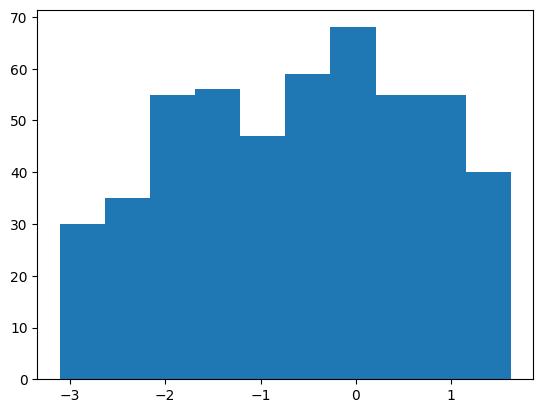

In [11]:
plt.hist(np.log10(np.array(data_stacks[0, ..., -2])))

In [22]:
# design a noise simulator function that takes raw values, adds noise, and then outputs features
import jax.random as jr
from functools import partial

num_features_input = 3 # this is how many get fed to the network

# WANT: Mstar, SFR, Zstar
# 0, -2, 4
@partial(jax.jit, static_argnums=(2))
def noise_simulator(key, data, cut=None):
  """noise simulator. takes in data of shape (n_gal, 15)
     returns: noisy realisation of network inputs """


  # output container
  data_ = jnp.zeros((n_d, num_features_input))

  # make sure to log10 the features that need doing
  data = data.at[:, 11].set(jnp.log10(data[:, 11])) # Mvir
  data = data.at[:, 10].set(jnp.log10(data[:, 10])) # T0
  data = data.at[:, 9].set(jnp.log10(data[:, 9]))   # n0
  data = data.at[:, -2].set(jnp.log10(data[:, 2]))  # SFR

  # now vary the noise amplitude to marginalise out
  key,rng = jr.split(key)
  amplitude = jr.uniform(rng, shape=(1,), minval=0.1, maxval=0.75)


  # add in data_stacks[:, ]

  # now add noise to the full log10(data) (e.g. 0.3 dex)
  data += jr.normal(key, shape=data.shape) * amplitude # 0.3 change to ~ U(0.1, 2.0)


  # finally, put into NN input format

  # log10(mstar)
  data_ = data_.at[:, 0].set(data[:,0]) # Mstar


  # log10 SFR
  #data_ = data_.at[:, 1].set(data[:, -2]) # SFR
  data_ = data_.at[:, 1].set(data[:, -2])

  # log10 Zstar stuff
  data_ = data_.at[:, 2].set(jnp.log10(10**data[:,4] / 10**data[:,0] / 0.02))


  # if cut specified, mask everything below cut
  if cut is not None:
    mask = (data_[:, 0] > cut)[:, jnp.newaxis]
    data_ = jnp.where(mask, data_, 0.0)

  return data_

In [23]:
#train val split
num_features = 15 # this is for full dataset, but inputs will be truncated by noise_simulator

from sklearn.model_selection import train_test_split
data_, data_test, theta_, theta_test = train_test_split(data_full, theta_full, test_size=0.2, random_state=42)


batch_size = 200
n_d = 500
n_train = data_.shape[0]

data_ = data_.reshape(-1, batch_size, n_d, num_features)
theta_ = theta_.reshape(-1, batch_size, 4)

# reshape the test data into batches
data_test = data_test.reshape(-1, batch_size, n_d, num_features)
theta_test = theta_test.reshape(-1, batch_size, 4)

In [24]:
data_.shape, theta_.shape, data_test.shape, theta_test.shape

((160, 200, 500, 15), (160, 200, 4), (40, 200, 500, 15), (40, 200, 4))

Now initialise your regression network. We're using a Fishnet network, which is a lot like a Deepset to operate on our permutation-invariant set of galaxies.

In [25]:
# initialise the regression (embedding) network

# FEEL FREE to play with the hidden channels here


key = jax.random.PRNGKey(0) # pseudo-random key for Jax network.
model = FishnetNetwork(
                        hidden_channels=[128,128,128],
                        n_p=4
)
w = model.init(key, jnp.ones((n_d,num_features_input)))
mle, score, F = model.apply(w, jnp.ones((n_d,num_features_input))) # this model outputs a prediction, an unweighted score vector, and a Fisher matrix.

In [26]:
num_features_input

3

In [ ]:
#@title training loop <font color='lightblue'>[run me]</font>

@jax.jit
def kl_loss(w, x_batched, theta_batched):

    def fn(x, theta):
       mle,score,F = model.apply(w, x)
       return mle, F

    mle, F = jax.vmap(fn)(x_batched, theta_batched)

    return -jnp.mean(-0.5 * jnp.einsum('ij,ij->i', (theta_batched - mle), \
                                             jnp.einsum('ijk,ik->ij', F, (theta_batched - mle))) \
                                                  + 0.5*jnp.log(jnp.linalg.det(F)), axis=0)


tx = optax.adam(learning_rate=1e-5)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(kl_loss)


epochs = 3000

# this is a hack to make the for-loop training much faster in jax
def body_fun(i, inputs):
    w,loss_val, opt_state, _data, _theta, key = inputs
    x_samples = _data[i]
    y_samples = _theta[i]

    # apply noise simulator
    keys = jr.split(key, x_samples.shape[0])
    x_samples = jax.vmap(noise_simulator)(keys, x_samples)

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)

    return w, loss_val, opt_state, _data, _theta, key


def val_body_fun(i, inputs):
    w,loss_val, _data, _theta, key = inputs
    x_samples = _data[i]
    y_samples = _theta[i]

    # apply noise simulator
    keys = jr.split(key, x_samples.shape[0])
    x_samples = jax.vmap(noise_simulator)(keys, x_samples)

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples)

    return w, loss_val, _data, _theta, key


key = jax.random.PRNGKey(999)

losses = jnp.zeros(epochs)
val_losses = jnp.zeros(epochs)
loss_val = 0.
val_loss_value = 0.
lower = 0
upper = n_train // batch_size

pbar = tqdm(range(epochs), leave=True, position=0)

for j in pbar:
      key,rng = jax.random.split(key)

      # shuffle data every epoch
      randidx = jax.random.permutation(key, jnp.arange(theta_.reshape(-1, 4).shape[0]), independent=True)
      _data = data_.reshape(-1, n_d, num_features)[randidx].reshape(batch_size, -1, n_d, num_features)
      _theta = theta_.reshape(-1, 4)[randidx].reshape(batch_size, -1, 4)

      #print(_data.shape)

      inits = (w, loss_val, opt_state, _data, _theta, key)

      w, loss_val, opt_state, _data, _theta, key = jax.lax.fori_loop(lower, upper, body_fun, inits)

      losses = losses.at[j].set(loss_val)


      # do validation set
      inits = (w, loss_val, data_test, theta_test, key)
      w, val_loss_value, data_test, theta_test, key = jax.lax.fori_loop(0, data_test.shape[0], val_body_fun, inits)
      val_losses = val_losses.at[j].set(val_loss_value)

      #val_losses.append(val_loss)
      pbar.set_description('epoch %d loss: %.5f  val loss: %.5f'%(j, loss_val, val_loss_value))


epoch 225 loss: -4.66590  val loss: -4.69569:   8%|▊         | 226/3000 [03:53<46:42,  1.01s/it]

In [ ]:
save_obj(w, "fishnets_w_3input")

(1.0, -11.0)

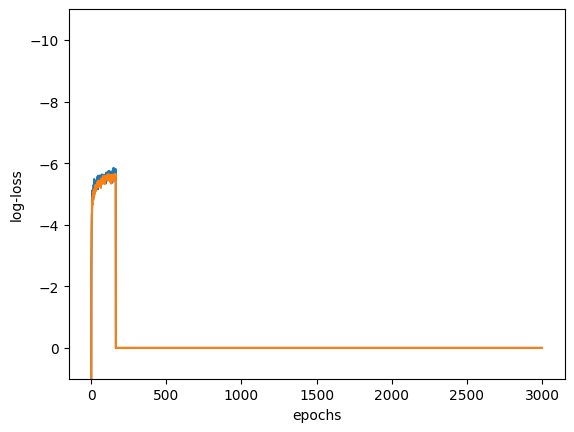

In [ ]:
plt.plot(losses)
plt.plot(val_losses)
plt.xlabel("epochs")
plt.ylabel("log-loss")
plt.ylim(1, -11)

In [ ]:
data_test = data_test.reshape(-1, n_d, num_features)
theta_test = theta_test.reshape(-1, 4)

In [ ]:
#w = load_obj("fishnets_w_3input.pkl")

In [ ]:
# make predictions over test set
testkey = jr.PRNGKey(40)
_app = lambda d: model.apply(w, d)

testsimulator = lambda k,d: noise_simulator(k,d, cut=None)

data_test_in = jax.vmap(testsimulator)(jr.split(testkey, data_test.shape[0]), data_test)
mle_pred,_,F_pred = jax.vmap(_app)(data_test_in.reshape(-1, n_d, num_features_input)[:])

In [ ]:
data_test_in[0, :, 0].min()

Array(5.8865514, dtype=float32)

### visualise regression network outputs
How well can the model produce point estimates for the parameters ?

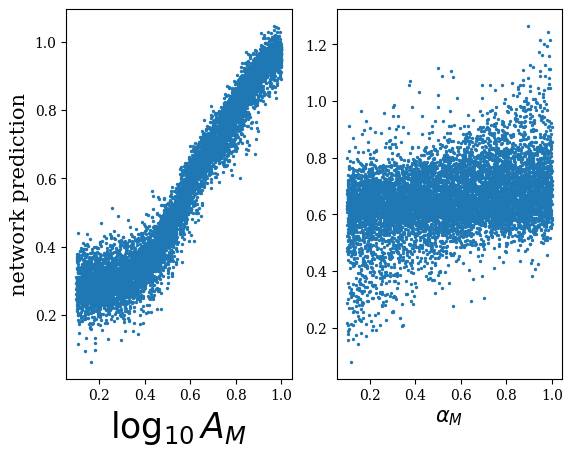

Text(0.5, 0, '$\\alpha_E$')

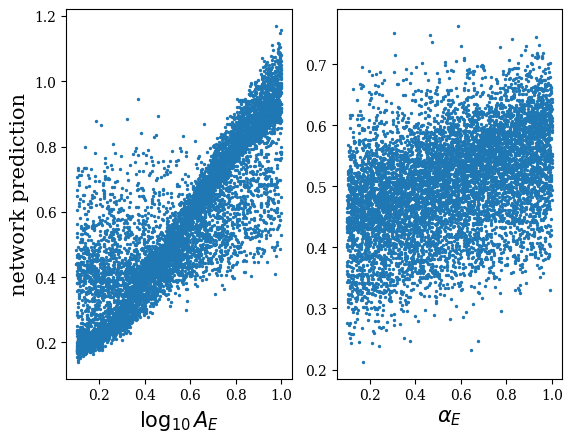

In [ ]:
params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$']

plt.subplot(121)
plt.scatter(theta_test.reshape(-1,4)[:, 0], mle_pred[:, 0], s=2)
plt.xlabel(params[0], fontsize=25)
plt.ylabel('network prediction', fontsize=15)

plt.subplot(122)
plt.scatter(theta_test.reshape(-1,4)[:, 1], mle_pred[:, 1], s=2)
plt.xlabel(params[1], fontsize=15)
plt.show()

plt.subplot(121)
plt.scatter(theta_test.reshape(-1,4)[:, 2], mle_pred[:, 2], s=2)
plt.ylabel('network prediction', fontsize=15)
plt.xlabel(params[2], fontsize=15)

plt.subplot(122)
plt.scatter(theta_test.reshape(-1,4)[:, 3], mle_pred[:, 3], s=2)

plt.xlabel(params[3], fontsize=15)



## what have we learned so far ?

Let's take a moment to see what our network can do now.

We took *sets* of galaxy properties and compressed them down into **point estimates** $\hat{\theta}$ for the parameters of our simulator.


Here the galaxy energy loading factors ($\eta_E$) are extremely sensitive to halo and stellar mass properties, while mass loading factors $(\eta_M)$ are more difficult to constrain from mass features alone. Viraj explains it best:

>"The physical reason for this is that increasing $\eta_M$ leads to a higher circumgalactic medium (CGM) density and enhanced cooling of gas back into the galaxy without suppressing star formation, thus leading to a similar $M_* − M_{\rm vir}$ relation. Instead, increasing $\eta_E$ can heat the
CGM, prevent gas accretion, reduce star formation and alter the normalization and shape of the $M_* − M_{\rm vir}$  relation. " --Viraj Pandya




## visualise error bars

A bonus feature of the Fishnets network we used is that we also have access to the Fisher (inverse-covariance) matrix for the learned outputs. Here we'll take a look at the *point estimates* for the posterior density *without having to run a normalising flow* (yet).

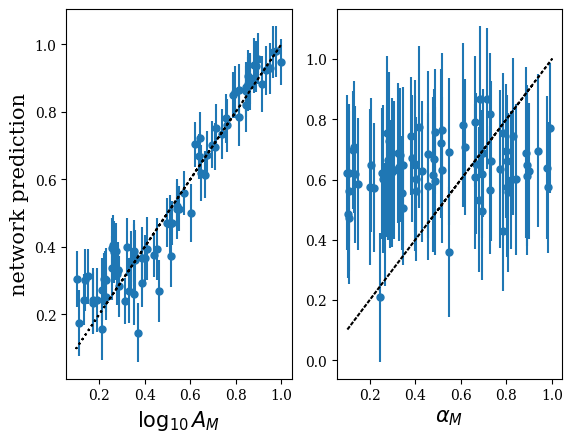

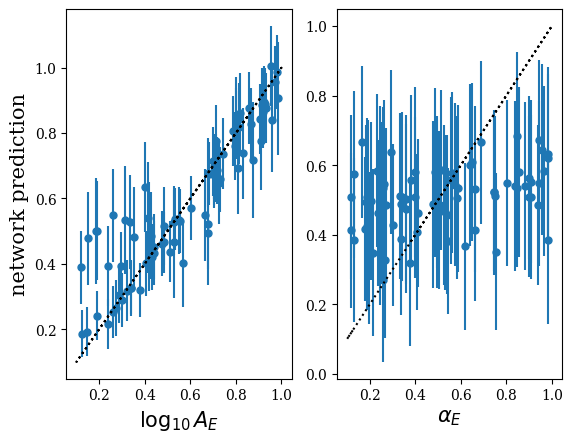

In [ ]:
skip = 100

plt.subplot(121)
ind = 0
plt.errorbar(theta_test.reshape(-1,4)[::skip, ind], mle_pred[::skip, ind],
             yerr=1./np.sqrt(F_pred[::skip, ind, ind]), fmt='o', markersize=5)

plt.plot(theta_test.reshape(-1,4)[:, ind], theta_test.reshape(-1,4)[:, ind], color='k', ls=':', zorder=10)
plt.xlabel(params[ind], fontsize=15)
plt.ylabel('network prediction', fontsize=15)


plt.subplot(122)
ind=1
plt.errorbar(theta_test.reshape(-1,4)[::skip, ind], mle_pred[::skip, ind],
             yerr=1./(np.sqrt(F_pred[::skip, ind, ind])), fmt='o', markersize=5)
plt.plot(theta_test.reshape(-1,4)[:, ind], theta_test.reshape(-1,4)[:, ind], color='k', ls=':', zorder=10)

plt.xlabel(params[ind], fontsize=15)
plt.show()


plt.subplot(121)
ind=2
plt.errorbar(theta_test.reshape(-1,4)[::skip, ind], mle_pred[::skip, ind],
             yerr=1./np.sqrt(F_pred[::skip, ind, ind]), fmt='o', markersize=5)
plt.plot(theta_test.reshape(-1,4)[:, ind], theta_test.reshape(-1,4)[:, ind], color='k', ls=':', zorder=10)

plt.xlabel(params[ind], fontsize=15)
plt.ylabel('network prediction', fontsize=15)

plt.subplot(122)
ind=3
plt.errorbar(theta_test.reshape(-1,4)[::skip, ind], mle_pred[::skip, ind], yerr=1./np.sqrt(F_pred[::skip, ind, ind]), fmt='o', markersize=5)
plt.plot(theta_test.reshape(-1,4)[:, ind], theta_test.reshape(-1,4)[:, ind], color='k', ls=':', zorder=10)

plt.xlabel(params[ind], fontsize=15)
plt.show()


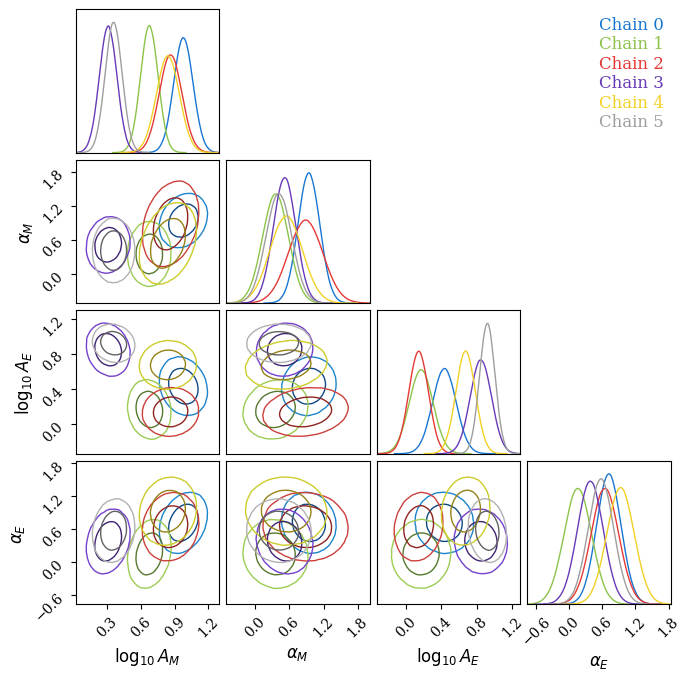

In [ ]:
#@title we can also visualise the Fishers over parameter space (if you're so inclined)

from chainconsumer import ChainConsumer

params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$']

cs = ChainConsumer()

for i in [3, 59, 300, 230, 1997, 42]:

    cs.add_covariance(theta_.reshape(-1, 4)[i], np.linalg.inv(F_pred[i]), parameters=params) #, color=corner_colors[0])

cs.configure(usetex=False)
cs.plotter.plot((7,7))

plt.show()

Save all outputs before moving on to the posterior inference !

In [ ]:
np.savez("fishnets_regression_outputs_3input",
         mle_pred=mle_pred,
         theta_test=theta_test)

# now look at ili posteriors with our regression summaries

Optionally install `ltu-ili` package here if you haven't done so already. We'll use the `.npz` file generated above for our summary-parameter pairs $(\hat{\theta}, \theta)$ to construct posteriors using a density estimator via the *Neural Posterior Estimation* (NPE) method.

In maths we're learning a model for
$$ p(\theta | \hat{\theta}) \propto p(\hat{\theta} | \theta) p(\theta) $$

where $\hat{\theta} = \text{net}(d; w)$ is the MLE point estimate from the Fishnets compression network we've optimised over the training set.

Note: installing `ltu-ili` here will reinstall pytorch and some other packages and will restart the session. This means you won't be able to use the trained model above (unless you save its weights).

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import torch

import numpy as np
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [ ]:
mle_pred.shape

(8000, 4)

In [ ]:
theta_test.shape

(40, 200, 4)

In [ ]:
fname = "fishnets_regression_outputs_3input.npz"
theta_test = np.load(fname)["theta_test"]
mle_pred = np.load(fname)["mle_pred"]


from copy import deepcopy
_s = deepcopy(theta_test)  # samples.cpu().numpy()
#_t = deepcopy(mle_pred)

# unnormalize
_s = [scaler.inverse_transform(_s[i][np.newaxis, :]) for i in range(_s.shape[0])]
_s = np.array(_s).squeeze()
#_t = scaler.inverse_transform(_t)

In [ ]:
_s.min(axis=0), _s.max(axis=0), # _t.min(axis=0), _t.max(axis=0)

(array([-1.999823 , -1.99936  , -1.9996163, -1.9998373], dtype=float32),
 array([ 1.9997154e+00, -9.3776718e-05, -7.9397747e-04, -1.1748258e-04],
       dtype=float32))

In [ ]:
# make a dataloader for the predicted thetas and true thetas
loader = NumpyLoader(x=np.array(mle_pred), theta=np.array(_s))



In [ ]:
mle_pred.shape, theta_test.shape

((1000, 4), (1000, 4))

In [ ]:
for i in range(4):
  print("feature %d max:"%(i), _s[:, i].max())
  print("feature %d min:"%(i) ,_s[:, i].min())

feature 0 max: 1.9997154
feature 0 min: -1.999823
feature 1 max: -9.377672e-05
feature 1 min: -1.99936
feature 2 max: -0.00079397747
feature 2 min: -1.9996163
feature 3 max: -0.00011748258
feature 3 min: -1.9998373


In [ ]:
# define a prior for the scaled thetas

prior = ili.utils.Uniform(low=[-2.0, -2.0, -2.0, -2.0], high=[2, 0, 0, 0], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
    #ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [ ]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

/usr/local/lib/python3.10/dist-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Neural network successfully converged after 460 epochs.

/usr/local/lib/python3.10/dist-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import sbi

# use latex font with optional style file
#mpl.style.use('/content/mcstyle.txt')

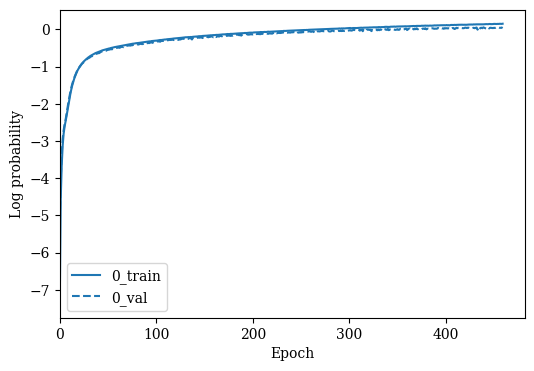

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [ ]:
# choose a random input
seed_in = 465
np.random.seed(seed_in)
ind = np.random.randint(len(theta_test))

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

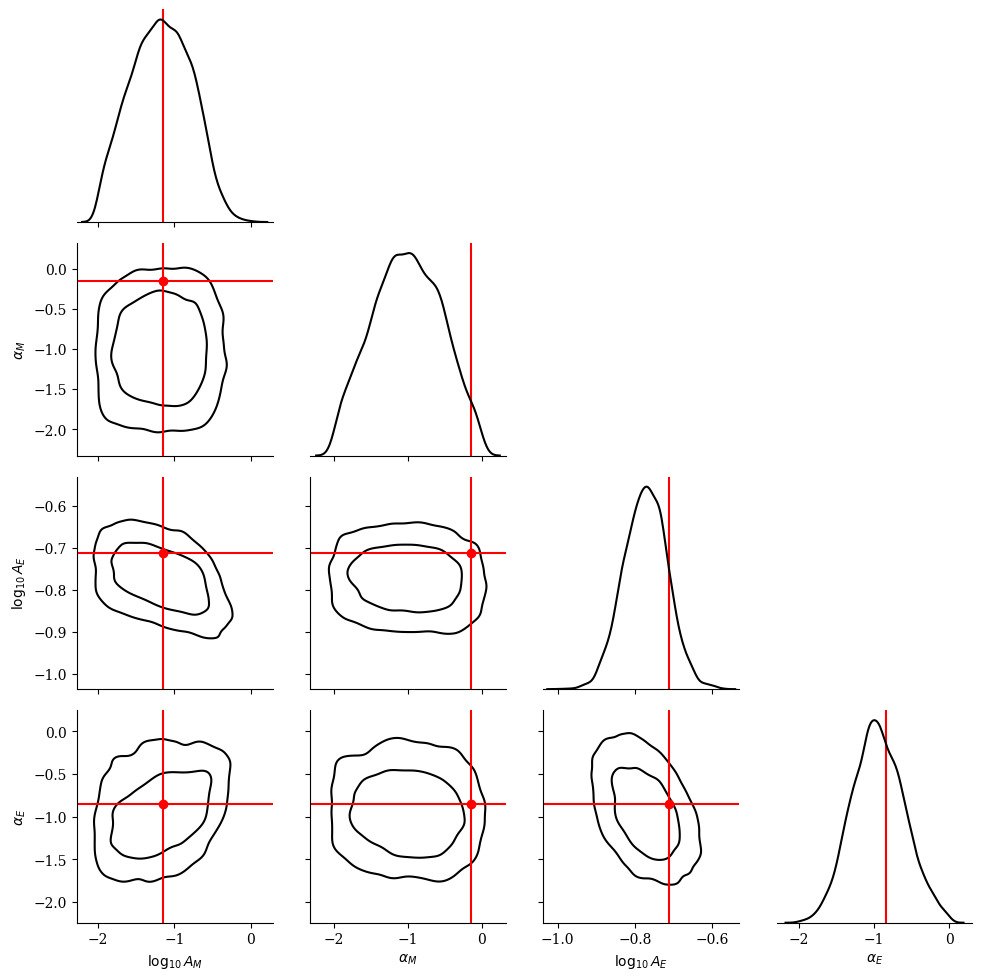

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this set of galaxies !

params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$']

metric = PlotSinglePosterior(
    num_samples=5000, sample_method='direct',
    labels=params
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = mle_pred[ind], theta_fid=_s[ind]
)
#plt.savefig("galaxy_posterior.png", dpi=500)

# load manga data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, hstack
from astropy.io import fits

import seaborn as sns

tread = Table.read('/content/drive/MyDrive/Colab Notebooks/sapphire-galev-2024/manga_merged_viraj.fits',format='fits')

print(len(tread), len(tread[tread['MW_Z_3ARCSEC'] != -9999]))
tread = tread[tread['MW_Z_3ARCSEC'] != -9999]

print(len(tread), len(tread[(tread['log_Mass']>9) & (tread['log_Mass']<10.7)]))
tread = tread[(tread['log_Mass']>9) & (tread['log_Mass']<10.7)]

print(len(tread), len(tread[np.log10(10**tread['log_SFR_Ha'] / 10**tread['log_Mass']) > -11]))
tread = tread[np.log10(10**tread['log_SFR_Ha'] / 10**tread['log_Mass']) > -11]


names = [name for name in tread.colnames if len(tread[name].shape) <= 1] # from error message without this line
df_final = tread[names].to_pandas()

df_final = df_final.dropna()

9927 9619
9619 4979
4979 3466


In [ ]:
df_final.shape[0]

1982

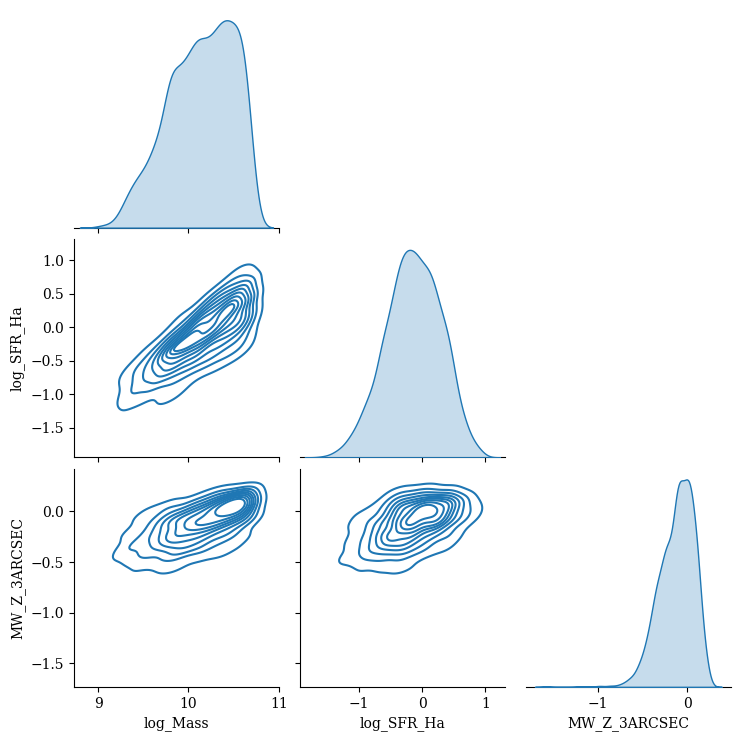

In [ ]:
sns.pairplot(df_final,vars=['log_Mass','log_SFR_Ha','MW_Z_3ARCSEC'],corner=True,kind='kde')#,diag_kind='kde')

In [ ]:
import pandas as pd
sapphire_datatest = pd.DataFrame(np.array(data_test_in[0, ..., :3].reshape(-1, 3)), columns=['log_Mass','log_SFR_Ha','MW_Z_3ARCSEC'])
sns.pairplot(sapphire_datatest,vars=['log_Mass','log_SFR_Ha','MW_Z_3ARCSEC'],corner=True,kind='kde')#,diag_kind='kde')


In [ ]:
data_test[:, :, 1].min()

Array(6.6575565, dtype=float32)

In [ ]:
# load in just the features we want
keyrand = jr.PRNGKey(201)
randidx = jr.choice(keyrand, jnp.arange(df_final.shape[0]), shape=(500,), replace=False)

data_target = jnp.array(df_final[['log_Mass','log_SFR_Ha','MW_Z_3ARCSEC']])[randidx][jnp.newaxis, ...]

#foo = jnp.zeros((500, 5))

#data_target = foo.at[:, :3].set(data_target)[jnp.newaxis, ...]


_app = lambda d: model.apply(w, d)
mle_target,_,F_target = jax.vmap(_app)(data_target)

In [ ]:
mle_target

Array([[-3.1785226 , -6.0330515 ,  0.78440046,  1.037215  ]], dtype=float32)

In [ ]:
data_test.shape

(8000, 500, 15)

In [ ]:
data_target.max(), np.array(sapphire_datatest).max(), data_target.min(), np.array(sapphire_datatest).min()

(Array(10.695518, dtype=float32),
 40.221233,
 Array(-1.4660295, dtype=float32),
 -2.2533875)

In [ ]:
data_target.shape

(500, 3)

In [ ]:
F_target

Array([[[ 32.125595  ,  -0.46966693, -15.030406  ,  -0.5463455 ],
        [ -0.46966693,   3.8822947 ,   3.5644467 ,  -2.9731927 ],
        [-15.030406  ,   3.5644467 , 406.62714   ,   1.6604884 ],
        [ -0.5463455 ,  -2.9731927 ,   1.6604884 ,  11.776363  ]]],      dtype=float32)

In [ ]:
mle_pred.max(), mle_target

(Array(1.1047895, dtype=float32),
 Array([[-5.0223365 ,  1.7691092 ,  0.75614107, -0.04069811]], dtype=float32))

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

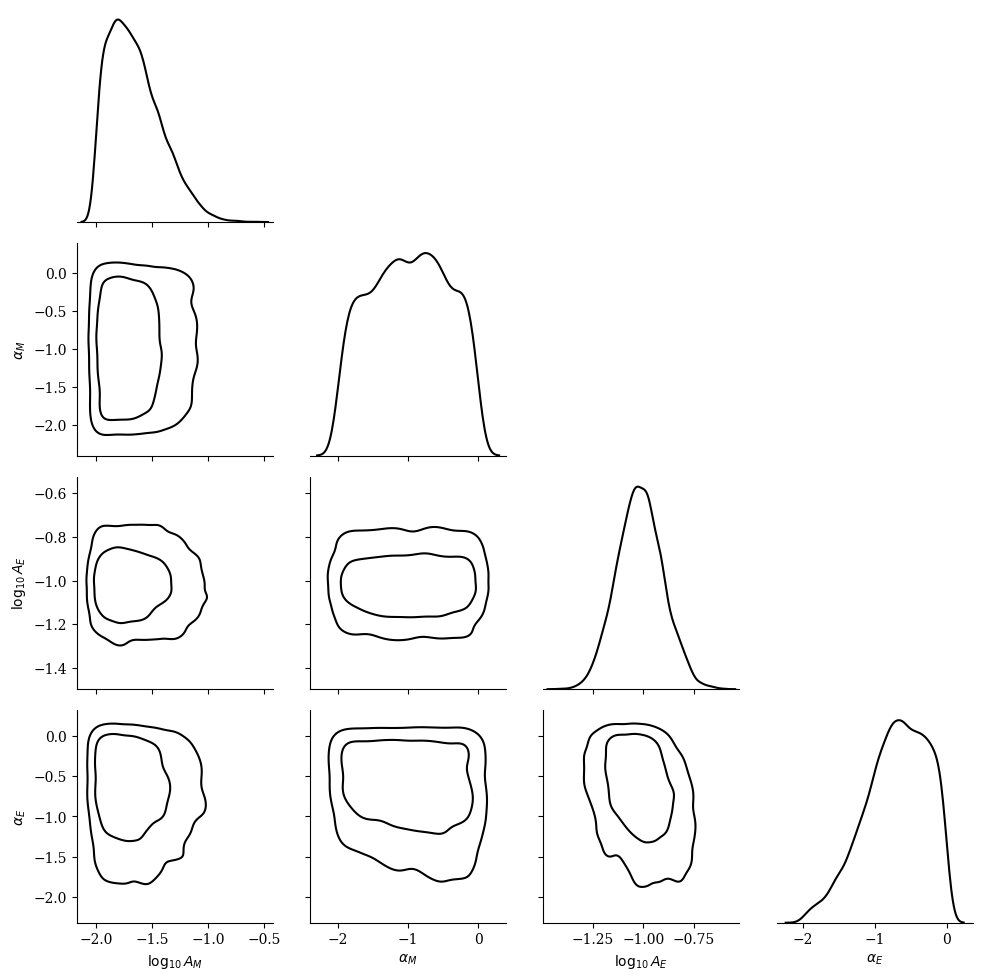

In [ ]:
params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$']

metric = PlotSinglePosterior(
    num_samples=5000, sample_method='direct',
    labels=params
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = np.array(mle_target), #mle_pred[ind],
    #theta_fid=_s[ind]
)